In [5]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Function to generate smoothly varying data
def smooth_data(start_value, trend, volatility, num_days):
    data = [start_value]
    for _ in range(num_days - 1):
        next_value = data[-1] + trend + np.random.normal(0, volatility)
        data.append(max(next_value, 0))  # Ensure values don't go negative
    return data

# Base Phase class
class Phase:
    def __init__(self, name, sleep_params, activity_params, hrv_params, eda_params, stress_params, light_params):
        self.name = name
        self.sleep_params = sleep_params
        self.activity_params = activity_params
        self.hrv_params = hrv_params
        self.eda_params = eda_params
        self.stress_params = stress_params
        self.light_params = light_params
        self.num_days = 30  # Number of days to simulate
        self.dates = [datetime.now() - timedelta(days=i) for i in range(self.num_days)]

    def generate_data(self):
        # Generate smooth data for each parameter
        sleep_hours = smooth_data(*self.sleep_params, self.num_days)
        steps = smooth_data(*self.activity_params, self.num_days)
        hrv = smooth_data(*self.hrv_params, self.num_days)
        eda = smooth_data(*self.eda_params, self.num_days)
        stress = smooth_data(*self.stress_params, self.num_days)
        light_exposure = smooth_data(*self.light_params, self.num_days)

        # Derived metrics
        calories = [s * 0.04 for s in steps]  # Calories burn proportional to steps
        screen_time = smooth_data(3 if self.name == "depressive" else 5, 0, 1, self.num_days)  # Screen time
        running_distance = [s / 2000 for s in steps]  # Estimate running distance
        exercise_time = [d * 10 for d in running_distance]  # Exercise time proportional to distance

        # Sleep subcomponents
        sleep_rem = smooth_data(0.25, 0, 0.05, self.num_days)
        sleep_deep = smooth_data(0.3, 0, 0.05, self.num_days)
        sleep_light = [1 - r - d for r, d in zip(sleep_rem, sleep_deep)]  # Light sleep = total - REM - deep

        # Create DataFrame
        data = {
            "Date": [date.strftime('%Y-%m-%d') for date in self.dates],
            "Sleep Hours": sleep_hours,
            "REM Sleep (%)": [x * 100 for x in sleep_rem],
            "Deep Sleep (%)": [x * 100 for x in sleep_deep],
            "Light Sleep (%)": [x * 100 for x in sleep_light],
            "Screen Time (hours)": screen_time,
            "Steps": steps,
            "Calories Burned": calories,
            "Running Distance (km)": running_distance,
            "Exercise Time (minutes)": exercise_time,
            "HRV": hrv,
            "EDA": eda,
            "Stress Level": stress,
            "Light Exposure (lux)": light_exposure
        }
        return pd.DataFrame(data)

    def save_to_csv(self):
        df = self.generate_data()
        df.to_csv(f'bipolar_data_phase_{self.name}.csv', index=False)

# Define specific phases as subclasses
class ManicPhase(Phase):
    def __init__(self):
        super().__init__(
            name="manic",
            sleep_params=(5, -0.2, 0.5),
            activity_params=(15000, 500, 2000),
            hrv_params=(70, 1, 5),
            eda_params=(0.2, 0.01, 0.05),
            stress_params=(70, 1, 5),
            light_params=(2000, 50, 500)
        )

class DepressivePhase(Phase):
    def __init__(self):
        super().__init__(
            name="depressive",
            sleep_params=(9, 0.2, 0.5),
            activity_params=(3000, -200, 500),
            hrv_params=(40, -0.5, 5),
            eda_params=(0.1, -0.005, 0.02),
            stress_params=(50, -0.5, 5),
            light_params=(500, -25, 100)
        )

class MixedPhase(Phase):
    def __init__(self):
        super().__init__(
            name="mixed",
            sleep_params=(7, 0, 1),
            activity_params=(8000, 0, 2000),
            hrv_params=(55, 0, 10),
            eda_params=(0.15, 0, 0.05),
            stress_params=(60, 0, 10),
            light_params=(1000, 0, 500)
        )

class RemissionPhase(Phase):
    def __init__(self):
        super().__init__(
            name="remission",
            sleep_params=(7, 0, 0.5),
            activity_params=(8000, 0, 1000),
            hrv_params=(65, 0, 5),
            eda_params=(0.15, 0, 0.03),
            stress_params=(40, 0, 5),
            light_params=(1200, 0, 200)
        )

# Instantiate and save data for all phases
phases = [ManicPhase(), DepressivePhase(), MixedPhase(), RemissionPhase()]
for phase in phases:
    phase.save_to_csv()
    print(f"Data for phase {phase.name} saved to bipolar_data_phase_{phase.name}.csv")


Data for phase manic saved to bipolar_data_phase_manic.csv
Data for phase depressive saved to bipolar_data_phase_depressive.csv
Data for phase mixed saved to bipolar_data_phase_mixed.csv
Data for phase remission saved to bipolar_data_phase_remission.csv


         Date  Sleep Hours  REM Sleep (%)  Deep Sleep (%)  Light Sleep (%)  \
0  2024-12-05     9.000000      25.000000       30.000000        45.000000   
1  2024-12-04     9.071758      26.226898       40.059301        33.713800   
2  2024-12-03     8.674175      22.708081       43.023411        34.268508   
3  2024-12-02     9.733983      18.859624       40.851290        40.289086   
4  2024-12-01    10.254496      15.735801       33.526724        50.737476   

   Screen Time (hours)        Steps  Calories Burned  Running Distance (km)  \
0             3.000000  3000.000000       120.000000               1.500000   
1             2.353685  2263.407268        90.536291               1.131704   
2             3.441533  1690.360294        67.614412               0.845180   
3             3.819430  1230.249326        49.209973               0.615125   
4             6.048677  1198.920723        47.956829               0.599460   

   Exercise Time (minutes)        HRV       EDA  Stress 

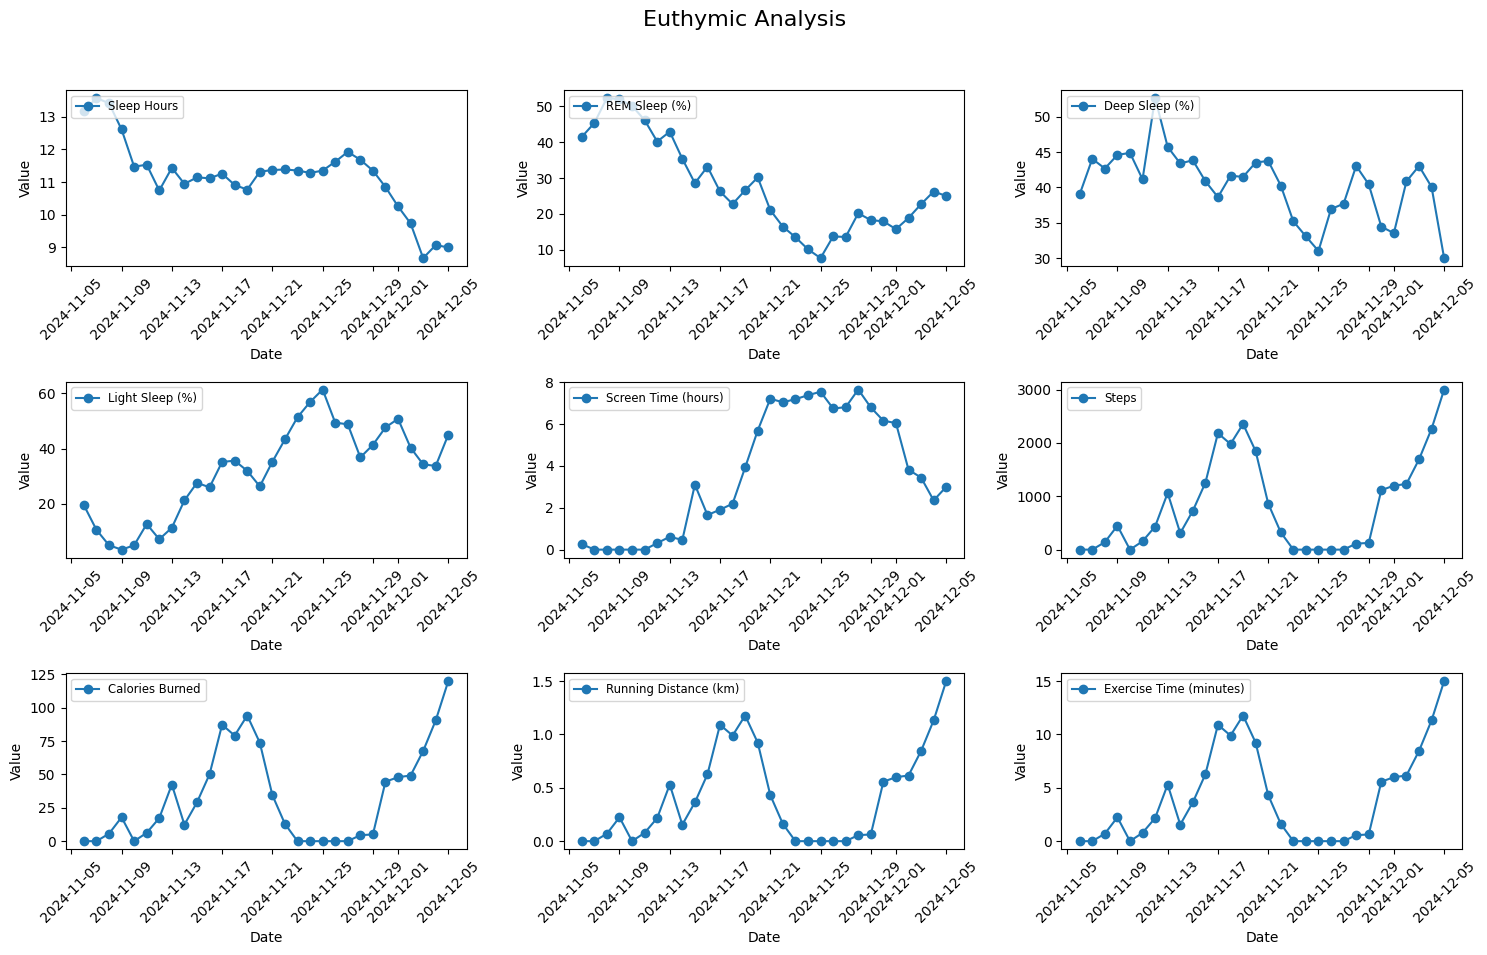

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

dat = ("/content/bipolar_data_phase_depressive.csv")
df = pd.read_csv(dat)  # Read the CSV file into a Pandas DataFrame
print(df.head())       # Display the first 5 rows of the DataFrame

# Convert 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'])

fig, axes = plt.subplots(3, 3, figsize=(15, 10))  # Create a 3x3 grid of subplots
fig.suptitle('Euthymic Analysis', fontsize=16)  # Set main title

# Plot each variable in a separate subplot
axes[0, 0].plot(df['Date'], df['Sleep Hours'], label='Sleep Hours', marker='o')
axes[0, 1].plot(df['Date'], df['REM Sleep (%)'], label='REM Sleep (%)', marker='o')
axes[0, 2].plot(df['Date'], df['Deep Sleep (%)'], label='Deep Sleep (%)', marker='o')
axes[1, 0].plot(df['Date'], df['Light Sleep (%)'], label='Light Sleep (%)', marker='o')
axes[1, 1].plot(df['Date'], df['Screen Time (hours)'], label='Screen Time (hours)', marker='o')
axes[1, 2].plot(df['Date'], df['Steps'], label='Steps', marker='o')
axes[2, 0].plot(df['Date'], df['Calories Burned'], label='Calories Burned', marker='o')
axes[2, 1].plot(df['Date'], df['Running Distance (km)'], label='Running Distance (km)', marker='o')
axes[2, 2].plot(df['Date'], df['Exercise Time (minutes)'], label='Exercise Time (minutes)', marker='o')


# Set labels and titles for each subplot
for ax in axes.flat:
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.legend(loc='upper left', fontsize='small')  # Adjust legend position if needed
    ax.tick_params(axis='x', rotation=45)  # Rotate x-axis labels

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout for title and subplots
plt.show()